In [1]:
import json
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# %%
def load_yaml_datasets(yaml_path):
    """
    Load a YAML file with a key "datasets" that lists
    dataset entries (each with a json_path and sampling_strategy).
    """
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    return data.get("datasets", [])

In [2]:
yaml_path = "/data/weka/ellisb/LLaVA-NeXT/scripts/ai2/exp/2025_01_30_mt5_mixed.yaml"
datasets_info = load_yaml_datasets(yaml_path)

In [3]:

# %%
# We will accumulate two types of records:
# 1. Conversation-level info (each JSONL line) to get the number of QA pairs per conversation.
# 2. Question-level info (each human turn) to count total questions by type.
conversation_records = []
question_records = []

# Process each dataset entry from the YAML file
for dataset in datasets_info:
    json_path = dataset["json_path"]
    # We assume these are JSONL files; skip others if needed.
    if not json_path.endswith('.jsonl'):
        continue

    # If paths are relative, you may need to adjust or use os.path.join
    if not os.path.exists(json_path):
        print(f"File not found: {json_path}")
        continue

    with open(json_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue  # skip empty lines
            try:
                convo = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Error parsing line: {e}")
                continue

            # Get an id for the conversation if available
            convo_id = convo.get("id", None)
            # Get the list of conversation turns
            turns = convo.get("conversations", [])
            # Select human turns (which we treat as the "questions")
            human_turns = [turn for turn in turns if turn.get("from") == "human"]
            # Count how many QA pairs (assuming one human turn is one question)
            qa_count = len(human_turns)

            # If possible, assign a task (question type) for the conversation.
            # We assume that most conversations are “homogeneous” (all QA turns share the same task).
            tasks = [turn.get("task", "unknown") for turn in human_turns]
            if len(tasks) > 0 and len(set(tasks)) == 1:
                task = tasks[0]
            else:
                # If a conversation mixes tasks, mark as "mixed"
                task = "mixed"

            conversation_records.append({
                "dataset": json_path,
                "conversation_id": convo_id,
                "qa_pairs": qa_count,
                "task": task
            })

            # For each human turn, store a record (for overall question counts)
            for idx, turn in enumerate(human_turns):
                question_records.append({
                    "dataset": json_path,
                    "conversation_id": convo_id,
                    "qa_index": idx + 1,
                    "task": turn.get("task", "unknown"),
                    "question": turn.get("value", "")
                })

In [4]:

# %%
# Convert our records into pandas DataFrames
df_convo = pd.DataFrame(conversation_records)
df_questions = pd.DataFrame(question_records)

# (Optional) Preview the data:
print("Conversation-level data:")
print(df_convo.head())
print("\nQuestion-level data:")
print(df_questions.head())

Conversation-level data:
                                             dataset conversation_id  \
0  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__0   
1  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__1   
2  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__2   
3  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__3   
4  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__4   

   qa_pairs              task  
0         5             mixed  
1         5             mixed  
2         5             mixed  
3         5             mixed  
4         2  obj_rel_distance  

Question-level data:
                                             dataset conversation_id  \
0  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__0   
1  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__0   
2  /data/weka/ellisb/vida/experiment_output/datas...   spoc_jan17__0   
3  /data/weka/ellisb/vida/experiment_out

In [5]:

# %%
# -------------------------------
# Tabulate total number of questions by type
# -------------------------------
questions_by_type = df_questions.groupby("task").size().reset_index(name="num_questions")
print("\nTotal number of questions by task:")
print(questions_by_type)

total_questions = len(df_questions)
print(f"\nTotal number of questions (across all datasets): {total_questions:,}")


Total number of questions by task:
                 task  num_questions
0  descriptive_binary          10810
1           obj_count           8194
2   obj_rel_direction          10178
3    obj_rel_distance          10152
4        temporal_rel          10730

Total number of questions (across all datasets): 50,064


/tmp/ipykernel_1427254/356339958.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=questions_by_type, x="task", y="num_questions", palette="tab20")


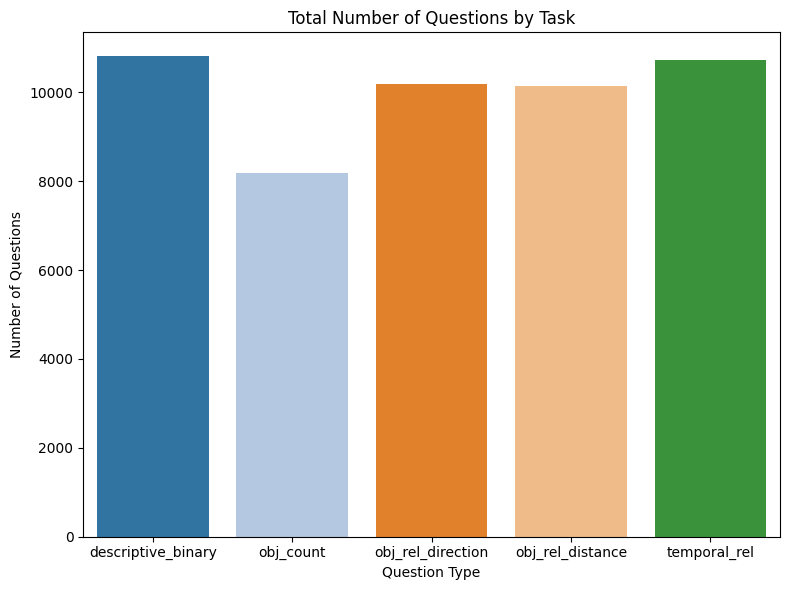

In [6]:

# -------------------------------
# Visualization: Total questions per question type
# -------------------------------
plt.figure(figsize=(8, 6))
sns.barplot(data=questions_by_type, x="task", y="num_questions", palette="tab20")
plt.title("Total Number of Questions by Task")
plt.xlabel("Question Type")
plt.ylabel("Number of Questions")
plt.tight_layout()
plt.show()


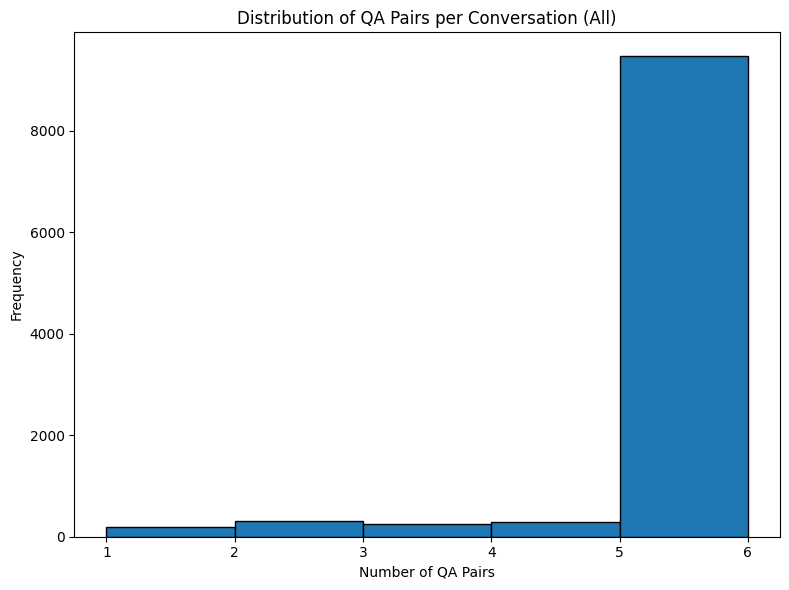

In [7]:

# %%
# -------------------------------
# Tabulate & visualize the distribution of QA pairs per conversation.
# Here we use the conversation-level dataframe.
# (We will show overall distribution as well as boxplots broken out by task.)
# -------------------------------

# Overall distribution (all conversations)
plt.figure(figsize=(8, 6))
plt.hist(df_convo["qa_pairs"], bins=range(1, df_convo["qa_pairs"].max() + 2), edgecolor="black")
plt.title("Distribution of QA Pairs per Conversation (All)")
plt.xlabel("Number of QA Pairs")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1427254/1014881454.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_convo_homog, x="task", y="qa_pairs", palette="tab20")


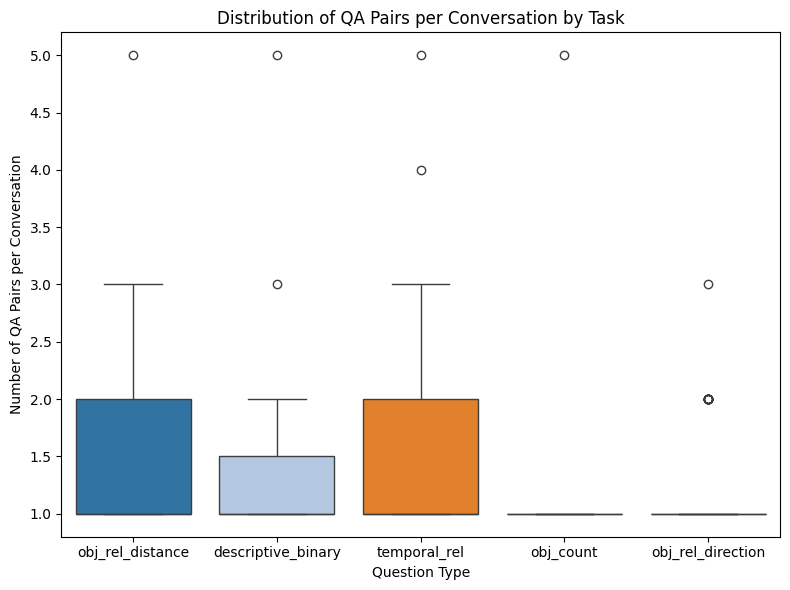

In [8]:

# If you want to break it down by question type,
# you may want to restrict to conversations that are homogeneous (i.e. not "mixed")
df_convo_homog = df_convo[df_convo["task"] != "mixed"]

# Boxplot showing the spread of QA pairs per conversation for each task
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_convo_homog, x="task", y="qa_pairs", palette="tab20")
plt.title("Distribution of QA Pairs per Conversation by Task")
plt.xlabel("Question Type")
plt.ylabel("Number of QA Pairs per Conversation")
plt.tight_layout()
plt.show()


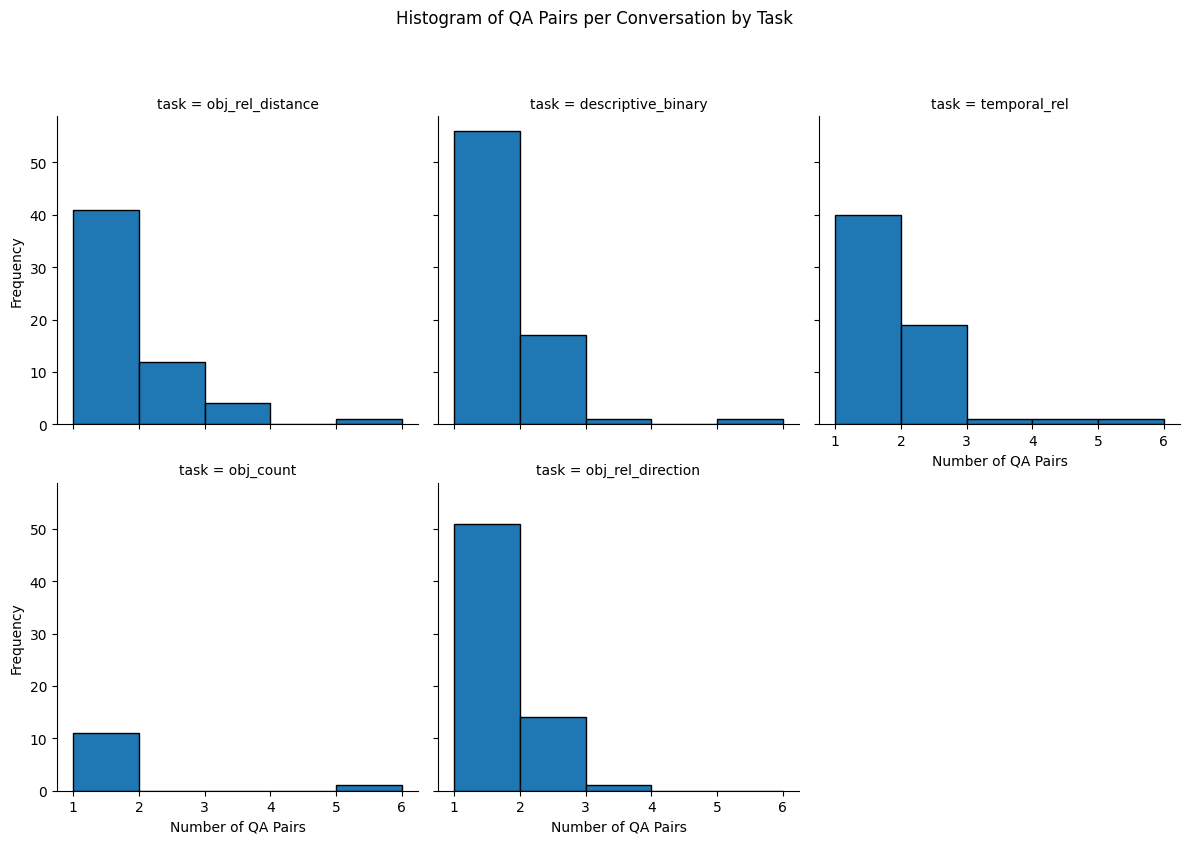

In [9]:

# Optionally, you can also use a FacetGrid to show histograms for each task:
g = sns.FacetGrid(df_convo_homog, col="task", col_wrap=3, height=4, sharex=True, sharey=True)
g.map(plt.hist, "qa_pairs", bins=range(1, df_convo_homog["qa_pairs"].max() + 2), edgecolor="black")
g.set_axis_labels("Number of QA Pairs", "Frequency")
g.fig.suptitle("Histogram of QA Pairs per Conversation by Task", y=1.05)
plt.tight_layout()
plt.show()


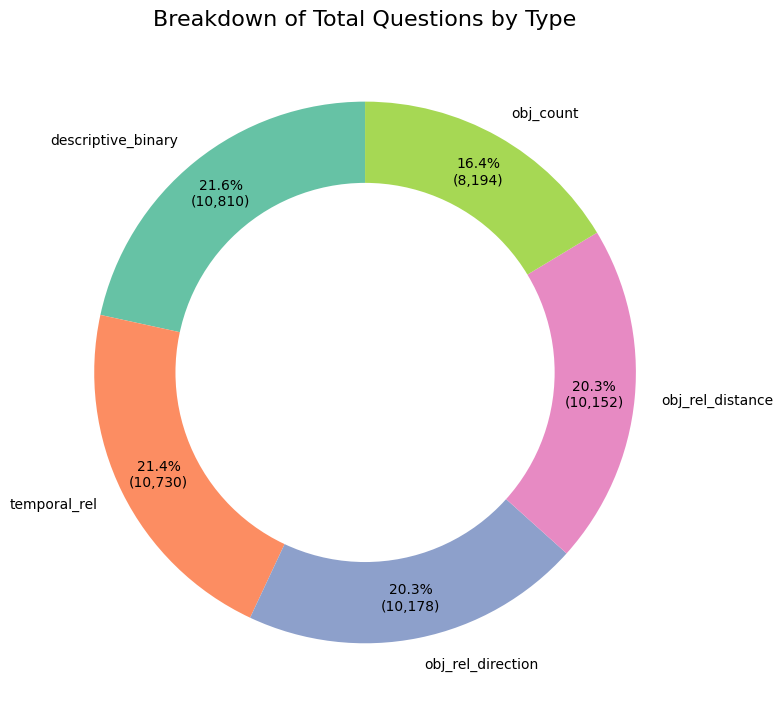

In [11]:
# Assuming df_questions exists and has a "task" column, we first aggregate:
questions_by_type = df_questions.groupby('task').size().reset_index(name='num_questions')
questions_by_type = questions_by_type.sort_values(by='num_questions', ascending=False)

# Choose a pleasant color palette (Set2 in this example)
colors = sns.color_palette("Set2", len(questions_by_type))

# Define a helper function to display both percentage and absolute value.
def make_autopct(values):
    """
    Returns a function that, given a percentage, computes the corresponding absolute count.
    """
    def my_autopct(pct):
        total = sum(values)
        absolute = int(round(pct/100. * total))
        return '{:.1f}%\n({:,})'.format(pct, absolute)
    return my_autopct

# Create the donut chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    questions_by_type['num_questions'],
    labels=questions_by_type['task'],
    autopct=make_autopct(questions_by_type['num_questions'].tolist()),
    startangle=90,
    colors=colors,
    pctdistance=0.85  # positions the percent labels
)

# Draw a white circle at the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Breakdown of Total Questions by Type", fontsize=16)
plt.tight_layout()
plt.show()